# Preenchimento Híbrido
Mostra o comportamento da rede utilizando os dois tipos de preenchimento. Essa simulação registra os recursos utilizados:

    - Número de Qubits criados
    - Número de EPRs criados

In [1]:
# Importando as dependências
from quantumnet.components import Controller, Network
from quantumnet.utils import generate_random_request, register_consumption, clear_file
from quantumnet.objects import time

Informações para a simulação

In [ ]:

# Caminho do arquivo de saída
path = "resultados/reativo/qubits_eprs_sync.csv"
# Limpa o arquivo de saída
clear_file(path)
# Sobre a rede
rede = Network()
rede.n_initial_eprs = 10
rede.n_initial_qubits = 10
row, col = 3, 4
rede.set_ready_topology("Grade", (row, col))
# Sobre o controlador
controlador = Controller(rede)
controlador.default_ttl = 100
# Sobre as requisições
fmin_range = (0.5, 1)
neprs_range = (2, 4)
num_requests = 100
requests = list(generate_random_request(len(rede.hosts)-1, fmin_range, neprs_range) for i in range(num_requests))

Preenchimento proativo

In [3]:
hosts = rede.hosts
for alice in hosts:
    for bob in hosts:
        controlador.add_match_route_rule_in_host_proactive(alice, bob, (0.5, 0.6), 5)
        controlador.add_match_route_rule_in_host_proactive(alice, bob, (0.8, 0.9), 5)

Funções responsáveis pela passagem de tempo

In [4]:
def update_rules(host, time_for_update):
    """
    Atualiza as regras de um host
    Args:
        host (Host): Host que terá as regras atualizadas
        time_for_update (int): Tempo para atualização das regras
    """
    # Percorre a tabela de fluxo do host
    for match in host.flow_table.copy():
        # Recebe o objeto da regra, somente
        rule = host.flow_table[match][1]
        # Incrementa a idade da regra
        for t in range(time_for_update):
            rule.increment_age()
        # Verifica se a regra expirou
        if rule.ttl <= rule.age:
            if rule.hit_count == 0:
                host.flow_table.pop(match)
                print(f"[Time {time.get_current_time()}] Regra {rule} expirada em {host}")
            else:
                print(f"Regra reutilizada {rule} em {host}")
                rule.hit_count = 0
                rule.age = rule.ttl/2

def update_time(time_for_update):
    """
    Atualiza o tempo e as regras

    Args:
        time_for_update (int): Tempo para incrementar o time-slot.
    """
    # Atualiza o tempo
    for t in range(time_for_update):
        time.increment()
        
        # Registra o consumo de recursos
        register_consumption(time.get_current_time(), rede.registry_of_resources, path)
        
        # Atualiza os recursos de 10 em 10
        if time.get_current_time() % 10 == 0:
            rede.refresh_resources(num_qubits=10, num_eprs=10)
            print(f"[Time {time.get_current_time()}] Recursos atualizados")
    # Atualiza as regras
    for host in rede.hosts:
        update_rules(rede.get_host(host), time_for_update)

Preenchimento reativo, baseado nas requests.

    - Demora 1 time-slot se a regra existe.
    - Demora 3 time-slots se uma nova regra precisa ser adicionada.

In [5]:
for request in requests:
        print(f"[Time {time.get_current_time()}] Processando requisição {request}...")
        alice = rede.get_host(request.alice)
        rule = alice.find_rule_by_request(request)

        if rule == False:  # Caso não exista um match na tabela
            request.starttime = time.get_current_time()
            update_time(3)
            controlador.add_match_route_rule_in_host_reactive(request)
            rule = alice.find_rule_by_request(request)
            controlador.run_rule(rule[1])
            request.endtime = time.get_current_time() 
            
        else:  # Caso já exista a regra
            request.starttime = time.get_current_time()
            update_time(1)
            controlador.run_rule(rule[1])
            request.endtime = time.get_current_time()
            # Registra no CSV como já registrado
        
        # Exibir informações da requisição
        print(f"Request {request}: Start Time = {request.starttime}, End Time = {request.endtime}")

[Time 0] Processando requisição R-1272C0...
Time-slot 1 registrado: Qubits = 120, EPRs = 170
Time-slot 2 registrado: Qubits = 120, EPRs = 170
Time-slot 3 registrado: Qubits = 120, EPRs = 170
Decisão aplicada: (Normal E2E,)
[BasicRule] Passo: 1
[BasicRule] Passo: 2
[BasicRule] Ação: Swap(8-4-5)
Running Swap(8-4-5)
Request R-1272C0: Start Time = 0, End Time = 3
[Time 3] Processando requisição R-4DE150...
Time-slot 4 registrado: Qubits = 120, EPRs = 170
[BasicRuleProactive] Passo: 1
[BasicRuleProactive] Ação: CreateEPR(4-0)
[BasicRuleProactive] Ação: CreateEPR(0-1)
[BasicRuleProactive] Passo: 2
[BasicRuleProactive] Ação: Swap(4-0-1)
Running Swap(4-0-1)
Request R-4DE150: Start Time = 3, End Time = 4
[Time 4] Processando requisição R-520380...
Time-slot 5 registrado: Qubits = 120, EPRs = 172
Time-slot 6 registrado: Qubits = 120, EPRs = 172
Time-slot 7 registrado: Qubits = 120, EPRs = 172
Decisão aplicada: (High Fidelity,)
Request R-520380: Start Time = 4, End Time = 7
[Time 7] Processando r

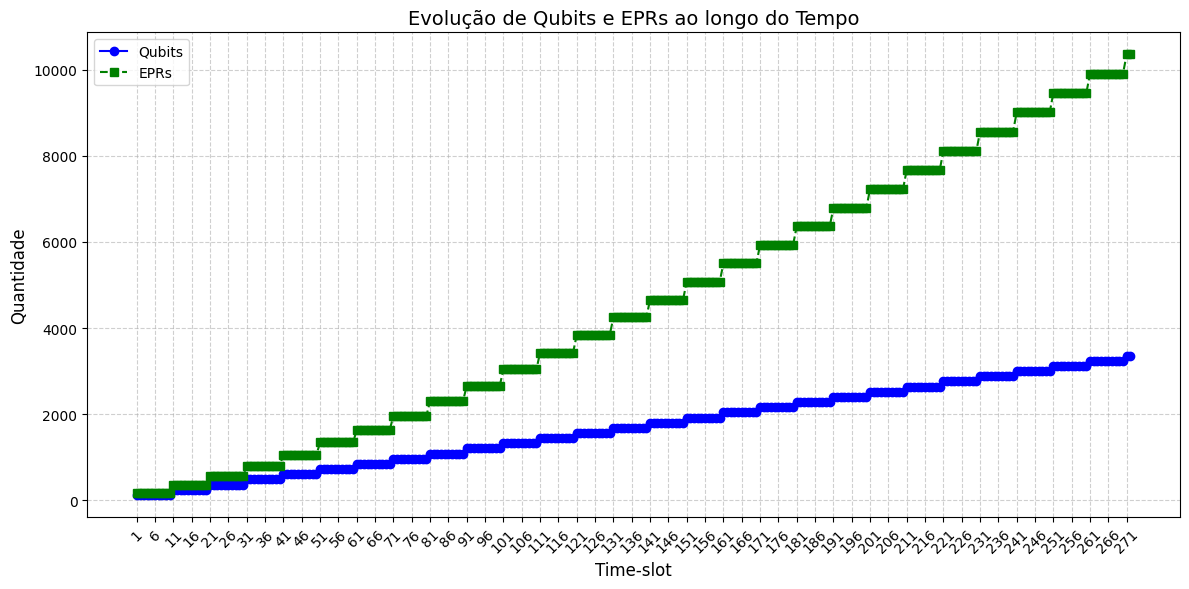

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_qubits_eprs(csv_file):
    """
    Lê um arquivo CSV sem cabeçalhos e plota gráficos mostrando a relação entre tempo (time-slot),
    qubits e EPRs, com o eixo X exibindo apenas valores de 5 em 5.
    
    Parâmetros:
        csv_file (str): Caminho para o arquivo CSV.
    """
    # Lê o arquivo CSV sem cabeçalhos
    data = pd.read_csv(csv_file, header=None, names=['time-slot', 'qubits', 'eprs'])

    # Cria o gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(data['time-slot'], data['qubits'], label='Qubits', marker='o', linestyle='-', color='blue')
    plt.plot(data['time-slot'], data['eprs'], label='EPRs', marker='s', linestyle='--', color='green')
    
    # Configurações do gráfico
    plt.title('Evolução de Qubits e EPRs ao longo do Tempo', fontsize=14)
    plt.xlabel('Time-slot', fontsize=12)
    plt.ylabel('Quantidade', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(visible=True, linestyle='--', alpha=0.6)

    # Configuração do eixo X para mostrar de 5 em 5
    xticks = data['time-slot'][::5]  # Pega os valores de time-slot a cada 5 linhas
    plt.xticks(xticks, labels=xticks, rotation=45)

    plt.tight_layout()
    
    # Exibe o gráfico
    plt.show()

plot_qubits_eprs(path)
# Exemplo de uso
# Salve o CSV no caminho 'dados.csv' e use:
# plot_qubits_eprs('dados.csv')